In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup 
from attention import AttentionLayer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from contractions import contractions

import warnings

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('./data/amazon-reviews/reviews.csv', nrows=100000)
data.drop_duplicates(subset=['Text'], inplace=True)
data.dropna(axis=0, inplace=True)

In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [81]:
stop_words = set(stopwords.words('english'))
START_TOKEN = '_START_'
END_TOKEN = '_END_'

def text_cleaner(text):
    s = text.lower()
    s = BeautifulSoup(s, "html.parser").text
    s = re.sub(r'\([^)]*\)', '', s)
    s = re.sub('"','', s)
    s = ' '.join([contractions[t] if t in contractions else t for t in s.split(" ")])
    
    tokens = [w for w in s.split() if not w in stop_words]
    selected_words = []
    
    
    for i in tokens:
        if len(i) >= 3:
            selected_words.append(i)

    return (' '.join(selected_words)).strip()


def summary_cleaner(text):
    s = re.sub('"','', text)
    s = ' '.join([contractions[t] if t in contractions else t for t in s.split(" ")])
    s = re.sub(r"'s\b", "", s)
    s = re.sub("[^a-zA-Z]", " ", s)
    s = s.lower()
    
    tokens = [ t if len(t) > 1 else '' for t in s.split() ]
    return START_TOKEN + ' ' + (' '.join(tokens)).strip() + ' ' + END_TOKEN
     

In [82]:
cleaned_text = [ text_cleaner(text) for text in data['Text'] ]

In [83]:
cleaned_summary = [ summary_cleaner(text) for text in data['Summary'] ]

In [84]:
data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis = 0, inplace=True)

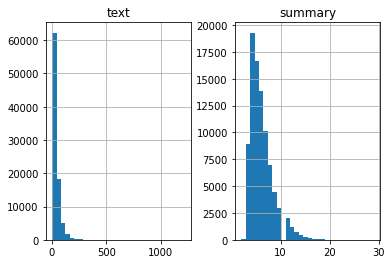

In [85]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [86]:
max_len_text = 80
max_len_summary = 10

In [87]:
x_tr, x_val, y_tr, y_val = train_test_split(
    data['cleaned_text'],
    data['cleaned_summary'],
    test_size=0.1,
    random_state=42,
    shuffle=True)

In [88]:
# Text tokenization
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

x_tr = x_tokenizer.texts_to_sequences(x_tr)
x_val = x_tokenizer.texts_to_sequences(x_val)

x_tr = pad_sequences(x_tr, maxlen=max_len_text, padding='post')
x_val = pad_sequences(x_val, maxlen=max_len_text, padding='post')

# Summary tokenization
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

y_tr = y_tokenizer.texts_to_sequences(y_tr)
y_val = y_tokenizer.texts_to_sequences(y_val)

y_tr = pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')

x_voc_size = len(x_tokenizer.word_index) + 1
y_voc_size = len(y_tokenizer.word_index) + 1

(x_voc_size, y_voc_size)

(59480, 14155)

In [117]:
# Model
from keras import backend as K
K.clear_session()

latent_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
encoder_embedding = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs)

# LSTM 1
encoder_lstm_01 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output_01, state_h_01, state_c_01 = encoder_lstm_01(encoder_embedding)

# LSTM 2
encoder_lstm_02 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output_02, state_h_02, state_c_02 = encoder_lstm_02(encoder_output_01)

# LSTM 3
encoder_lstm_03 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm_03(encoder_output_02)

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding_layer = Embedding(y_voc_size, latent_dim, trainable=True)
decoder_embedding = decoder_embedding_layer(decoder_inputs)

# LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# Attention Layer
attention_layer = AttentionLayer(name='attention_layer')
attention_out, attention_states = attention_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_result = decoder_dense(decoder_concat_input)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_result)
model.summary()

200
200
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 200)      11896000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 200), (N 320800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________

In [118]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [119]:
history=model.fit(
    [x_tr, y_tr[:,:-1]], 
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
    epochs=5,
    callbacks=[es],
    batch_size=512,
    validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/5
156/156 [==============================] - 584s 4s/step - loss: 3.3510 - val_loss: 2.8910
Epoch 2/5
156/156 [==============================] - 623s 4s/step - loss: 2.9024 - val_loss: 2.7595
Epoch 3/5
156/156 [==============================] - 640s 4s/step - loss: 2.7418 - val_loss: 2.6204
Epoch 4/5
156/156 [==============================] - 604s 4s/step - loss: 2.5853 - val_loss: 2.5036
Epoch 5/5
156/156 [==============================] - 531s 3s/step - loss: 2.4717 - val_loss: 2.4261


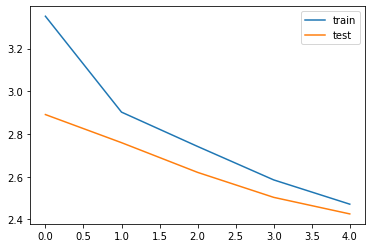

In [120]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [121]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [122]:
# Inference
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim))

# Get the embeddings of the decoder sequence
decoder_embedding_inference = Embedding(y_voc_size, latent_dim, trainable=True)(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs_inference, state_h_inference, state_c_inference = decoder_lstm(
    decoder_embedding_inference, 
    initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attention_layer([decoder_hidden_state_input, decoder_outputs_inference])
decoder_concat_inference = Concatenate(axis=-1, name='concat')([decoder_outputs_inference, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs_inference = decoder_dense(decoder_concat_inference)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs_inference] + [state_h_inference, state_c_inference])

In [123]:
encoder_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 80, 200)           11896000  
_________________________________________________________________
lstm (LSTM)                  [(None, 80, 200), (None,  320800    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 80, 200), (None,  320800    
_________________________________________________________________
lstm_2 (LSTM)                [(None, 80, 200), (None,  320800    
Total params: 12,858,400
Trainable params: 12,858,400
Non-trainable params: 0
_________________________________________________________________


In [124]:
decoder_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 200)    2831000     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 200)]        0                                            
_______________________________________________________________________________________

In [125]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
            
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token != 'end'):
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


def seq2summary(input_seq):
    newString=''
    
    for i in input_seq:
      if ((i != 0 and i != target_word_index['start']) and i != target_word_index['end']):
        newString = newString + reverse_target_word_index[i] + ' '
        
    return newString


def seq2text(input_seq):
    newString= ''
    
    for i in input_seq:
      if i != 0:
        newString = newString + reverse_source_word_index[i] + ' '
        
    return newString

In [126]:
for i in range(20):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: really good tea enough cranberry pomegranite taste right definately buy brand again 
Original summary: great refreshing 
Predicted summary:  tea and and and and and tea


Review: pantry goods amazon good deals point grabbed big pack albacore tuna well well the cans arrived incredibly dented made wonder cans could sold ways due quality cans the tuna really strange look bought bumblebee tuna remember bad this supposed white albacore water worst quality tuna ever bought tuna look like white albacore all like regular flaky grainy browner textured regular tuna none pale steak like albacore consistency tuna cans all it literally worst quality albacore tuna ever remember buying friendly 
Original summary: terrible quality must be 
Predicted summary:  cans but but and cans cans cans


Review: bought product review saying product france so product china stated label sampled product yet disappointed fault amazon reviewer maybe europe get product france product says packed american roland